In [1]:
# Import necessary libraries
import spacy
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch


In [2]:
# Load the 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
labels = newsgroups.target


In [3]:
# Load the spaCy model
nlp = spacy.load('en_core_web_md')


In [4]:
# Define a function to vectorize text using tok2vec
def tok2vec_text(text):
    doc = nlp(text)
    return doc.vector


In [5]:

# Vectorize the texts
text_vectors = np.array([tok2vec_text(text) for text in texts])


In [6]:
# Perform MiniBatch K-Means clustering
n_clusters = 20  # You can adjust this as needed
minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)
cluster_labels = minibatch_kmeans.fit_predict(text_vectors)

In [7]:
# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(text_vectors)


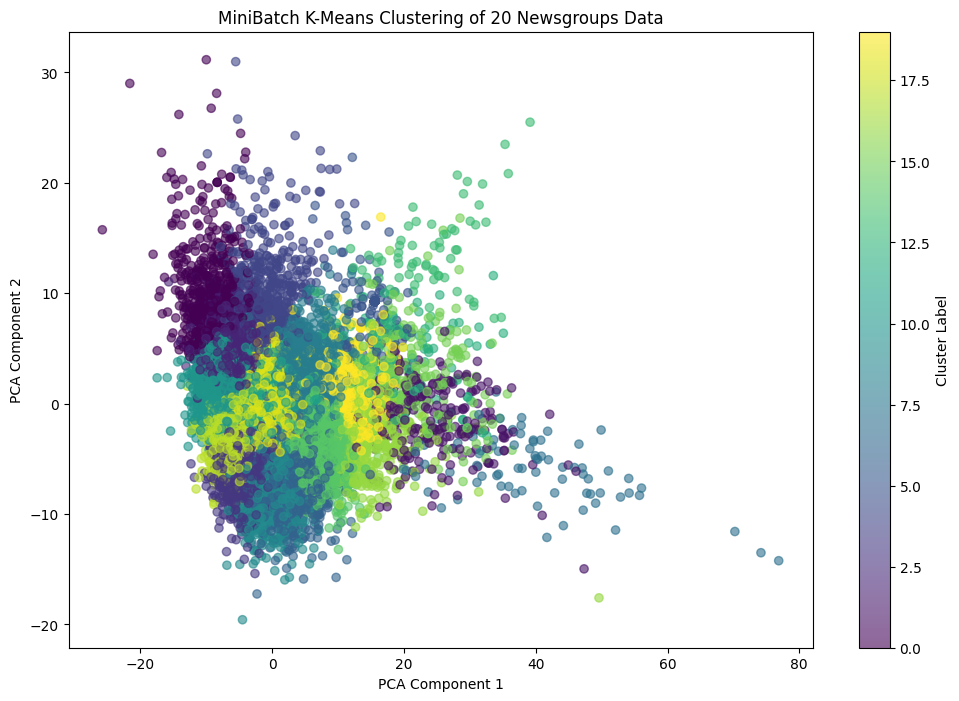

In [8]:
# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MiniBatch K-Means Clustering of 20 Newsgroups Data')
plt.show()

In [10]:
# Neuralized K-Means class definition
class NeuralizedKMeans(torch.nn.Module):
    def __init__(self, kmeans):
        super().__init__()
        self.n_clusters = kmeans.n_clusters
        self.kmeans = kmeans
        K, D = kmeans.cluster_centers_.shape
        self.W = torch.empty(K, K-1, D, dtype=torch.double)
        self.b = torch.empty(K, K-1, dtype=torch.double)
        for c in range(K):
            for kk in range(K-1):
                k = kk if kk < c else kk + 1
                centroid_c = torch.tensor(kmeans.cluster_centers_[c], dtype=torch.double)
                centroid_k = torch.tensor(kmeans.cluster_centers_[k], dtype=torch.double)
                self.W[c, kk] = 2 * (centroid_c - centroid_k)
                self.b[c, kk] = (torch.norm(centroid_k)**2 - torch.norm(centroid_c)**2)

    def h(self, X):
        z = torch.einsum('ckd,nd->nck', self.W, X) + self.b
        return z

    def forward(self, X, c=None):
        h = self.h(X)
        out = h.min(-1).values
        if c is None:
            return out.max(-1).values
        else:
            return out[:,c]
def inc(z, eps=1e-9):
    return z + eps * (2 * (z >= 0) - 1)

def beta_heuristic(model, X):
    fc = model(X)
    return 1 / fc.mean()

def neon(model, X, beta):
    R = torch.zeros_like(X)
    if not torch.is_tensor(beta):
        beta = torch.tensor(beta)
    for i in range(X.shape[0]):
        x = X[[i]]
        ### forward
        h = model.h(x)
        out = h.min(-1).values
        c = out.argmax()
        ### backward
        pk = torch.nn.functional.softmin(beta * h[:,c], dim=-1)
        Rk = out[:,c] * pk
        knc = [k for k in range(model.n_clusters) if k != c]
        Z = model.W[c] * (x - 0.5 * (model.kmeans.cluster_centers_[[c]] + model.kmeans.cluster_centers_[knc]))
        Z = Z / inc(Z.sum(-1, keepdims=True))
        R[i] = (Z * Rk.view(-1,1)).sum(0)
    return R

In [11]:
# Convert data to tensors for Neuralized K-Means
X_tensor = torch.tensor(text_vectors, dtype=torch.double)
y_tensor = torch.tensor(labels, dtype=torch.long)

In [12]:
# Initialize Neuralized K-Means
model = NeuralizedKMeans(minibatch_kmeans)


In [13]:
# Sample some data points for explanation
sample_indices = np.random.choice(np.arange(len(texts)), size=5, replace=False)

Text: 

 My first thought is Ross Perot .   After further consideration , I think he 'd 
 be more likely to try to win it ... but come in a disappointing third . 

 Try Bill Gates .   Try Sam Walton 's kids . 

 Matt
Cluster assignment: 2 (probability 1.00)
True class: 14


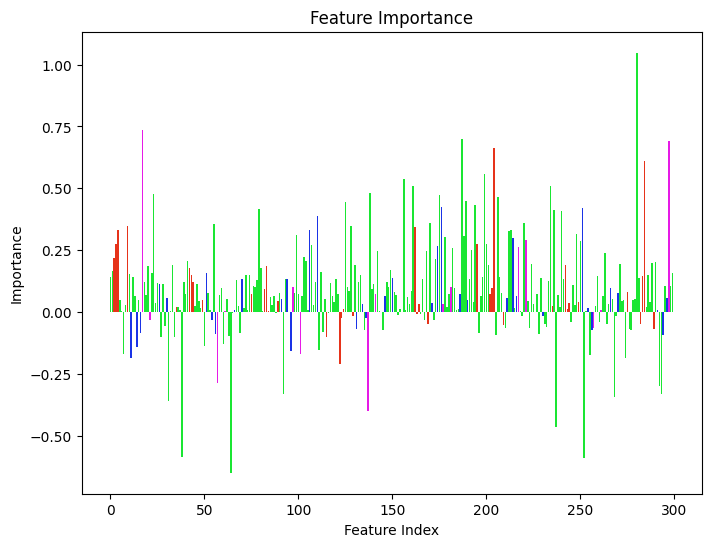

--------------------------------------------------------------------------------
Text: there is a file out there ( look for it with archie ) that is called 
 ' theref22.zip ' which has lots of info on various PC things , 
 amongst which is also a detailed description of all Floppy controller 
 commands , I think hard drive controller commands are not there . 

 it is possible to read an entire track including all gaps , sector 
 headers etc .    by setting sector size to something very large ( like 
 8 K ) .
Cluster assignment: 3 (probability 1.00)
True class: 3


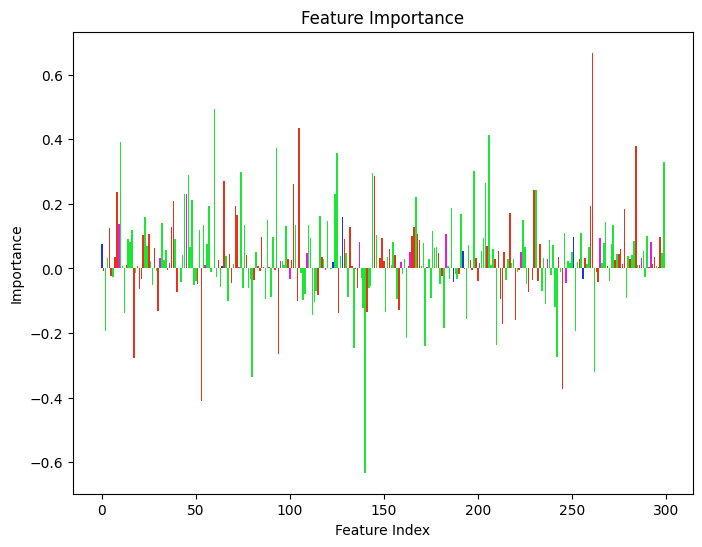

--------------------------------------------------------------------------------
Text: hi all , i got several emails and a couple news replies and i guess i 
 shoulda went into more detail ... Being my anxiety level is peaking and you 
 folks have no clue who I am I may as well post the specifics and see what 
 you people think regarding my previous post . 
 To recap i applied to 20 schools total , 16 of which were MD and 4 DO . 

 as it stands now i have had 13 rejects , 4 interviews ( 2 MD and 2 DO ) , the 
 results of which are 2 waiting lists ( 1 MD and one DO ) 

 3 schools i heard nothing from at all . 

 I have contacted all institutions other than the rejects and they have no 
 info whatsoever to tell me . 

 I have taken a good mix to apply to .. 2 - 3 top schools a bunch of middles 
 and a few " safety "   ( funny that most of my safety schools were the first 
 to reject me ) 

 my index is at like a 3.5 mcats were R7 P9 B10 WQ and R7 P9 B11 WR 
 I could nt get the damn readi

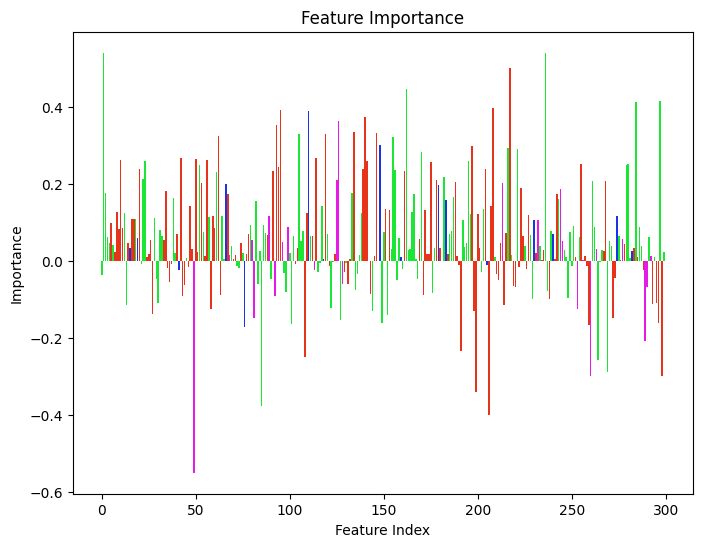

--------------------------------------------------------------------------------
Text: Newsgroup : sci.electronics 
 From : martin.vuille@synapse.org 
 Subject : Electronic Design 

 Does anyone know the telephone number for the circulation department 
 of ' Electronic Design ' magazine ? 

 MV
Cluster assignment: 15 (probability 1.00)
True class: 12


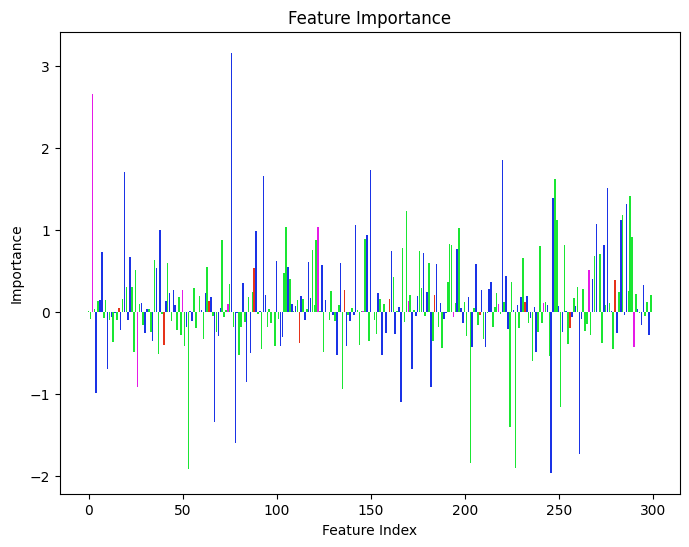

--------------------------------------------------------------------------------


In [14]:
# Sample 4 indices from correctly classified samples if available
if len(sample_indices) > 0:
    sample_indices = np.random.choice(sample_indices, size=min(4, len(sample_indices)), replace=False)

    for i in sample_indices:
        sample_text = texts[i]
        sample_vector = X_tensor[[i]]
        R = neon(model, sample_vector, beta=beta_heuristic(model, X_tensor))

        logit = model.forward(sample_vector).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()

        # Highlight words based on feature importance R
        doc = nlp(sample_text)
        token_importance = R[0].detach().numpy()  # Assuming R is for the first sample
        token_scores = {token.text: score for token, score in zip(doc, token_importance)}

        # Normalize the importance scores to range between 0 and 1
        max_score = max(token_scores.values())
        min_score = min(token_scores.values())
        normalized_scores = {token: (score - min_score) / (max_score - min_score) for token, score in token_scores.items()}

        # Define a function to map a normalized score to a color
        def score_to_color(score):
            if score < 0.25:
                return (0.1, 0.2, 0.9)  # Shades of blue for low importance
            elif score < 0.5:
                return (0.1, 0.9, 0.2)  # Shades of green for medium importance
            elif score < 0.75:
                return (0.9, 0.2, 0.1)  # Shades of red for high importance
            else:
                return (0.9, 0.1, 0.9)  # Shades of purple for very high importance
        # Construct highlighted text with different colors based on importance
        highlighted_text = []
        token_colors = []
        for token in doc:
            if token.text in normalized_scores:
                score = normalized_scores[token.text]
                color = score_to_color(score)
                highlighted_text.append(f"\033[38;2;{int(color[0]*255)};{int(color[1]*255)};{int(color[2]*255)}m{token.text}\033[m")  # Highlight in RGB color
                token_colors.append(color)
            else:
                highlighted_text.append(token.text)
                token_colors.append((0, 0, 0))  # Default color (black)

        highlighted_text = " ".join(highlighted_text)
        print(f'Text: {highlighted_text}')
        print(f'Cluster assignment: {cluster_labels[i]} (probability {prob:.2f})')
        print(f'True class: {labels[i]}')

        # Plot feature importance from R with corresponding colors
        plt.figure(figsize=(8, 6))
        plt.bar(range(len(R[0])), R[0].detach().numpy(), color=[score_to_color(score) for score in normalized_scores.values()])
        plt.title('Feature Importance')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.show()
        print('-' * 80)

else:
    print("No correctly classified samples found in the selected subset.")
